In [87]:
% pylab inline
import numpy as np
import math
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.axes3d import Axes3D
import pylab as pb
from matplotlib import cm
from scipy.stats import norm
from scipy.special import gamma
from scipy.stats import chi
from scipy.stats import cauchy

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


[-4.0, 4.0, 0, 2.0]

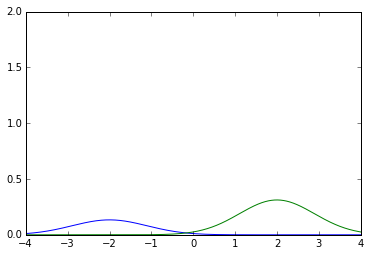

In [88]:
X_eval = np.linspace(-4.0,4.0,1000)
mean_1 = -2.0
mean_2 = 2.0
var_1 = var_2 = 0.8
Y1 = norm.pdf(X_eval, mean_1, np.sqrt(var_1))*0.3
Y2 = norm.pdf(X_eval, mean_2, np.sqrt(var_2))*0.7
pb.plot(X_eval, Y1)
pb.plot(X_eval, Y2)
plt.axis([-4.0, 4.0, 0, 2.0])

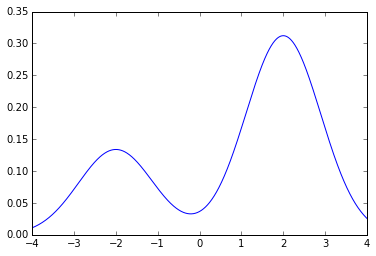

In [89]:
Y_mix = Y1 + Y2
pb.plot(X_eval, Y_mix)

In [90]:
N = 1000
choices = np.random.binomial(1,0.3, N)
X = np.zeros(N)
for i in range(0,choices.shape[0]):
    if choices[i]:
        X[i] = np.asscalar(np.random.normal(mean_1, np.sqrt(var_1),1))
    else:
        X[i] = np.asscalar(np.random.normal(mean_2, np.sqrt(var_2),1))

In [91]:
def parzenmio(X, X_ev, h, N):
    P_X = np.copy(X)
    msum = np.zeros(N)
    for j in range(0,N):
        msum += norm.pdf(X_ev, X[j], np.sqrt(h))
    P_X = msum/N
    return P_X

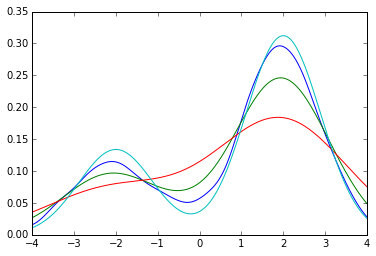

In [92]:
P_X = parzenmio(X, X_eval, 0.1, N)
pb.plot(X_eval, P_X)
P_X = parzenmio(X, X_eval, 0.5, N)
pb.plot(X_eval, P_X)
P_X = parzenmio(X,X_eval, 1.6, N)
pb.plot(X_eval, P_X)
pb.plot(X_eval, Y_mix)

## Sampling using MCMC Metropolis Hastings

In [112]:
def metropolisHastingSample(n_samples, mean_prop=0.0, variance_prop=1.0):
    #mean_prop = 0.0
    #variance_prop = 30.0
    z_ant = np.asscalar(np.random.normal(mean_prop, variance_prop, 1))
    #n_samples = 1000
    z_samples = np.zeros(n_samples)
    z_samples[0] = z_ant
    for i in range(1, n_samples):
        z_p = np.asscalar(np.random.normal(z_ant, variance_prop, 1))
        mix1 = (0.3*norm.pdf(z_p, mean_1, np.sqrt(var_1))) + (0.7*norm.pdf(z_p, mean_2, np.sqrt(var_2)))
        mix2 = (0.3*norm.pdf(z_ant, mean_1, np.sqrt(var_1))) + (0.7*norm.pdf(z_ant, mean_2, np.sqrt(var_2)))
        mnum = norm.pdf(z_ant, z_p, variance_prop)
        mdem = norm.pdf(z_p, z_ant, variance_prop)
        mnum = mnum*mix1
        mdem = mdem*mix2
        tmp_val = mnum/mdem
        a = min(tmp_val, 1.0)
        u0 = np.asscalar(np.random.uniform(size=1))
        if(u0 <= a):
            z_samples[i] = z_p
        else:
            z_samples[i] = z_ant
        z_ant = z_samples[i]
    return z_samples

Estiamted Potential Scale Reduction for var= 2.0  :  1.01926354456
Estiamted Potential Scale Reduction for var= 10.0  :  1.00401863371
Estiamted Potential Scale Reduction for var= 20.0  :  0.999806011738
Estiamted Potential Scale Reduction for var= 50.0  :  1.02050631105


/Users/juangilopez/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:16: RuntimeWarning: invalid value encountered in double_scalars
/Users/juangilopez/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:16: RuntimeWarning: divide by zero encountered in double_scalars


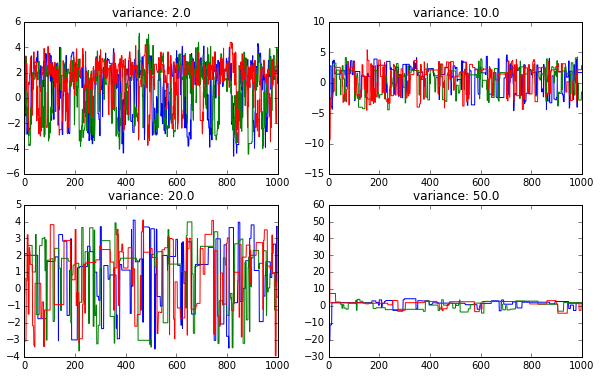

In [116]:
#pb.plot(X_eval, Y_mix)
cont = 1
np.random.seed(2)
pb.figure(2, figsize=(10,6))
nchains = 3
nsamples = 1000
Super_samples = np.zeros((nchains, nsamples))
for i in [2.0, 10.0, 20.0, 50.0]:
    pb.subplot(2,2,cont)
    pb.title('variance: '+str(i))
    #pb.set_xlim([0,100])
    #pb.axis([0, 1000, -2*i, 2*i])
    intr_sec_mean = np.zeros(nchains)
    w_arr = np.zeros(nchains)
    for j in range(0, nchains):
        z_sample1 = metropolisHastingSample(nsamples, mean_prop=0.0, variance_prop=i)
        Super_samples[j,:] = z_sample1
        input_t = np.arange(z_sample1.shape[0])
        intr_sec_mean[j] = np.sum(z_sample1)/nsamples
        mdiff = z_sample1 - intr_sec_mean[j]
        w_arr[j] = np.dot(mdiff,mdiff)*(1.0/(nsamples - 1))
        pb.plot(input_t, z_sample1)
    
    bet_sec_mean = np.sum(intr_sec_mean)/nchains
    mval = intr_sec_mean - bet_sec_mean
    B = (nsamples/(nchains - 1))*np.dot(mval,mval)
    W = np.sum(w_arr)/nchains
    V_estim = (((nsamples - 1.0)/nsamples)*W) + ((1.0/nsamples)*B)
    espr = np.sqrt(V_estim/W)
    print 'Estiamted Potential Scale Reduction for var=',i,' : ', espr
    cont += 1
    #P_Z = parzenmio(z_samples, X_eval, 0.5, 1000)
    #mlabel = str(i)
    #pb.plot(X_eval, P_Z, label=mlabel)
    #pb.legend(loc='upper left')

### Sampling from a Cauchy Distribution

In [58]:
def metropolisHastingSampleCauchy(mean_prop=0.0, variance_prop=1.0):
    #mean_prop = 0.0
    #variance_prop = 30.0
    z_ant = np.asscalar(np.random.normal(mean_prop, variance_prop, 1))
    n_samples = 1000
    z_samples = np.zeros(n_samples)
    z_samples[0] = z_ant
    for i in range(1, n_samples):
        z_p = np.asscalar(np.random.normal(z_ant, variance_prop, 1))
        mix1 = 1.0/(1 + (z_p**2.0))
        mix2 = 1.0/(1 + (z_ant**2.0))
        mnum = norm.pdf(z_ant, z_p, variance_prop)
        mdem = norm.pdf(z_p, z_ant, variance_prop)
        mnum = mnum*mix1
        mdem = mdem*mix2
        tmp_val = mnum/mdem
        a = min(tmp_val, 1.0)
        u0 = np.asscalar(np.random.uniform(size=1))
        if(u0 <= a):
            z_samples[i] = z_p
        else:
            z_samples[i] = z_ant
        z_ant = z_samples[i]
    return z_samples

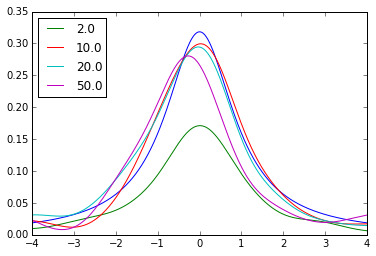

In [72]:
X_eval = np.linspace(-4.0,4.0,1000)
Y_cauchy = cauchy.pdf(X_eval)
pb.plot(X_eval, Y_cauchy)
for i in [2.0, 10.0, 20.0, 50.0]:
    z_samples = metropolisHastingSampleCauchy(variance_prop=i)
    P_Z = parzenmio(z_samples, X_eval, 0.3, 1000)
    mlabel = str(i)
    pb.plot(X_eval, P_Z, label=mlabel)
    pb.legend(loc='upper left')

### Gibbs Sampling

In [85]:
N = 2
#np.random.seed(2)
z_ini = np.random.randn(N)
T = 1000
real_mean = np.zeros(2)
real_mean[0] = 1.0
real_mean[1] = 2.0
real_cov = np.eye(2)
real_cov[0,1] = 0.9
real_cov[1,0] = 0.9
z_ant = z_ini
all_z = np.zeros((T,2))
for i in range(0,T):
    mean_0 = real_mean[0] + (real_cov[0,1]*(1.0/real_cov[1,1])*(z_ant[1] - real_mean[1]))
    cov_0 = real_cov[0,0] + (real_cov[0,1]*(1.0/real_cov[1,1])*(real_cov[1,0]))
    z_ant[0] = np.random.normal(mean_0, cov_0, 1)
                             
    mean_1 = real_mean[1] + (real_cov[1,0]*(1.0/real_cov[0,0])*(z_ant[0] - real_mean[0]))
    cov_1 = real_cov[0,0] + (real_cov[1,0]*(1.0/real_cov[0,0])*(real_cov[0,1]))
    z_ant[1] = np.random.normal(mean_1, cov_1, 1)
    all_z[i,:] = z_ant

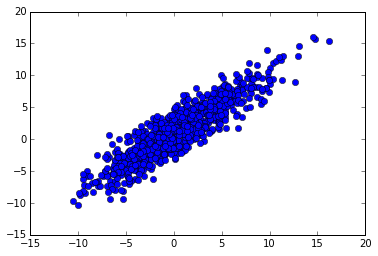

In [86]:
pb.plot(all_z[:,0], all_z[:,1], 'bo')